In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import math
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
#Récuperation de la donnée :
def get_historical_data(quote):
    end = datetime.now()
    start = datetime(end.year-2, end.month, end.day)
    df = yf.download(quote, start=start, end=end)
    return(df)

indices_cac40 = ['^FCHI', 'ETH-EUR']
cac40 = get_historical_data(indices_cac40)
print(cac40.head())

[*********************100%%**********************]  2 of 2 completed


              Adj Close                     Close                      High  \
                ETH-EUR        ^FCHI      ETH-EUR        ^FCHI      ETH-EUR   
Date                                                                          
2022-03-13  2304.254883          NaN  2304.254883          NaN  2377.266602   
2022-03-14  2367.468750  6369.939941  2367.468750  6369.939941  2371.163330   
2022-03-15  2389.115234  6355.000000  2389.115234  6355.000000  2430.131836   
2022-03-16  2515.069336  6588.640137  2515.069336  6588.640137  2520.275879   
2022-03-17  2536.099365  6612.520020  2536.099365  6612.520020  2546.896240   

                                 Low                      Open               \
                  ^FCHI      ETH-EUR        ^FCHI      ETH-EUR        ^FCHI   
Date                                                                          
2022-03-13          NaN  2291.580811          NaN  2357.968750          NaN   
2022-03-14  6421.080078  2293.180664  6271.819824  

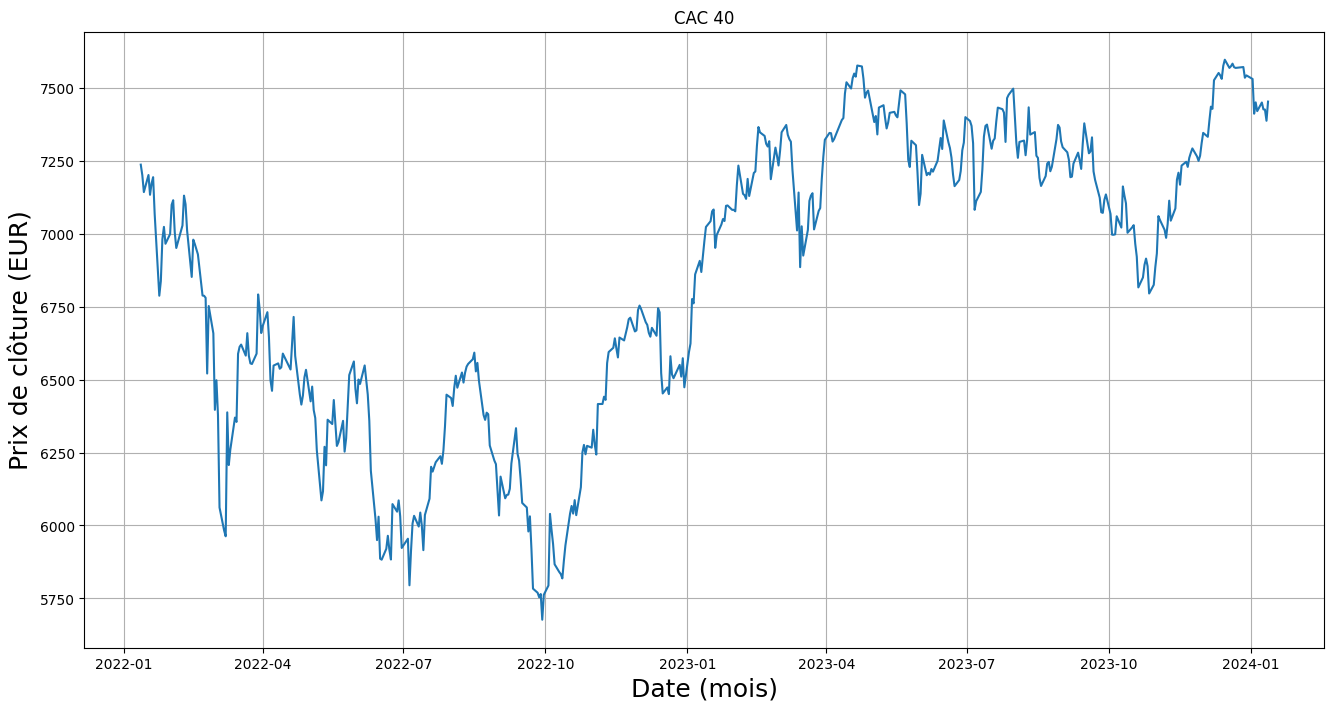

In [37]:
# Plot prix du CAC40 (historique)
# cac40 = get_historical_data('CAC 40')
plt.figure(figsize=(16,8))
plt.title('CAC 40')
plt.plot(cac40['Close'])
plt.xlabel('Date (mois)', fontsize=18)
plt.ylabel('Prix de clôture (EUR)', fontsize=18)
plt.grid()
plt.show()

In [38]:
#Filtrer la donnée :
cac41 = cac40.filter(['Close'])
cac40_dataset = cac41.values
cac40_dataset

array([[7237.18994141],
       [7201.14013672],
       [7143.        ],
       [7201.64013672],
       [7133.83007812],
       [7172.97998047],
       [7194.16015625],
       [7068.58984375],
       [6787.79003906],
       [6837.95996094],
       [6981.95996094],
       [7023.79980469],
       [6965.87988281],
       [6999.20019531],
       [7099.49023438],
       [7115.27001953],
       [7005.62988281],
       [6951.37988281],
       [7009.25      ],
       [7028.41015625],
       [7130.87988281],
       [7101.54980469],
       [7011.60009766],
       [6852.20019531],
       [6979.97021484],
       [6964.97998047],
       [6946.81982422],
       [6929.62988281],
       [6788.33984375],
       [6787.60009766],
       [6780.66992188],
       [6521.04980469],
       [6752.43017578],
       [6658.83007812],
       [6396.49023438],
       [6498.02001953],
       [6378.37011719],
       [6061.66015625],
       [5982.27001953],
       [5962.95996094],
       [6387.83007812],
       [6207.200

In [41]:
#Préparation de la donnée pour le model ML :
training_data_lenght = math.ceil(len(cac40_dataset) * 0.8)

In [42]:
# Transformer la donnée (entre 0 et 1) :
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(cac40_dataset)

In [43]:
# Création des blocs de données pour le model ML :
train_data = scaled_data[0:training_data_lenght, :]
x_training = []
y_training = []
for i in range(60, len(train_data)):
    x_training.append(train_data[i-60:i, 0])
    y_training.append(train_data[i, 0])
x_training, y_training = np.array(x_training), np.array(y_training)
x_training = np.reshape(x_training, (x_training.shape[0], x_training.shape[1], 1))
x_training.shape

(352, 60, 1)

In [44]:
# Construction du model LSTM :
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_training.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [45]:
# Apprentisage du model LSTM :
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_training, y_training, batch_size=1, epochs=10)

Epoch 1/10
352/352 [==============================] - 14s 18ms/step - loss: 0.0120
Epoch 2/10
352/352 [==============================] - 6s 18ms/step - loss: 0.0056
Epoch 3/10
352/352 [==============================] - 7s 19ms/step - loss: 0.0043
Epoch 4/10
352/352 [==============================] - 6s 17ms/step - loss: 0.0040
Epoch 5/10
352/352 [==============================] - 6s 18ms/step - loss: 0.0035
Epoch 6/10
352/352 [==============================] - 7s 19ms/step - loss: 0.0025
Epoch 7/10
352/352 [==============================] - 7s 19ms/step - loss: 0.0027
Epoch 8/10
352/352 [==============================] - 6s 18ms/step - loss: 0.0027
Epoch 9/10
352/352 [==============================] - 6s 18ms/step - loss: 0.0020
Epoch 10/10
352/352 [==============================] - 6s 17ms/step - loss: 0.0022


In [46]:
# Création de la donnée test :
test_data = scaled_data[training_data_lenght - 60: , :]
x_testing = []
y_testing = cac40_dataset[training_data_lenght: , :]
for i in range(60, len(test_data)):
    x_testing.append(test_data[i-60:i, 0])
x_testing = np.array(x_testing)
x_testing = np.reshape(x_testing, (x_testing.shape[0], x_testing.shape[1], 1))

In [47]:
# Vérification de la donnée Test et la donnée du model :
predictions = model.predict(x_testing)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean((predictions - y_testing) ** 2))
rmse

4/4 [==============================] - 5s 27ms/step


52.117964073025746

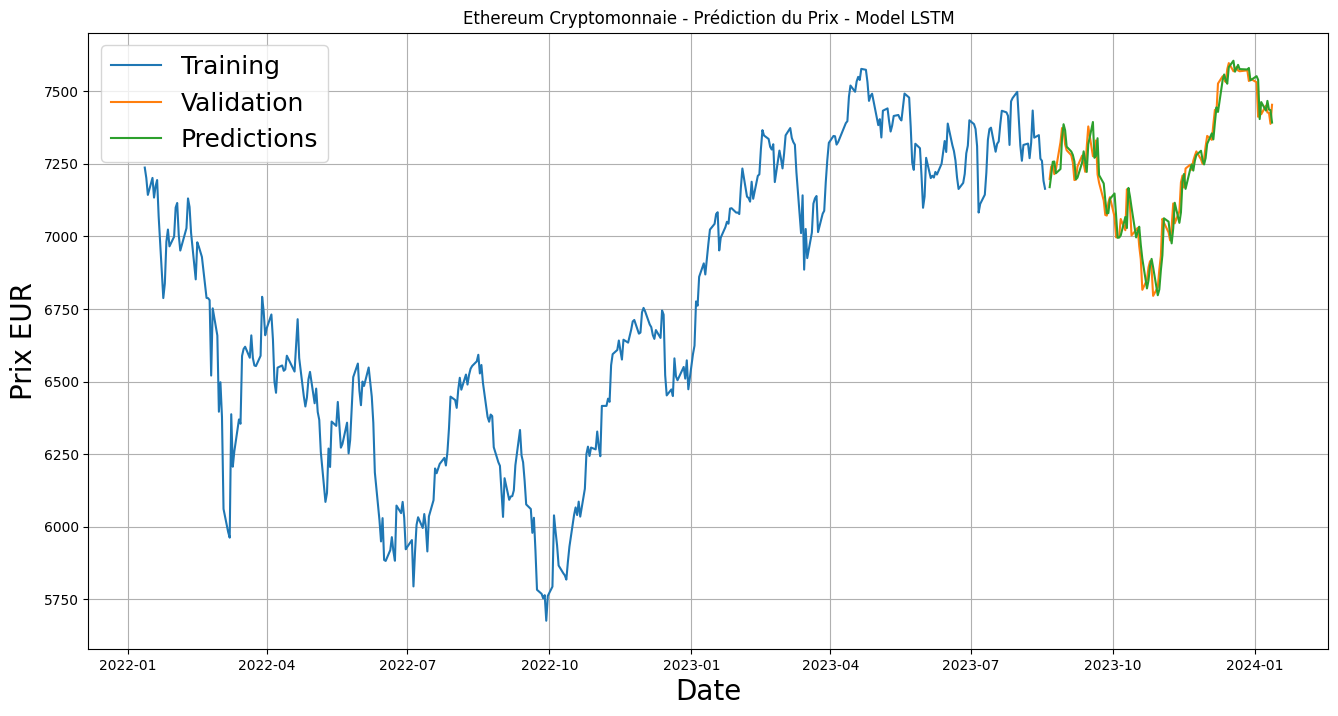

In [48]:
# Plot des prédictions :
train = cac41[:training_data_lenght].copy()
valid = cac41[training_data_lenght:].copy()
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Ethereum Cryptomonnaie - Prédiction du Prix - Model LSTM')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Prix EUR', fontsize=20)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Training', 'Validation', 'Predictions'], loc='upper left', fontsize=18)
plt.grid()
plt.show()

In [50]:
# Dernier Prix et Prédiction du Prix :
valid

,Close,Predictions
Date,,
2023-08-21,7198.060059,7169.722168
2023-08-22,7240.879883,7210.302246
2023-08-23,7246.620117,7257.062012
2023-08-24,7214.459961,7258.028809
2023-08-25,7229.600098,7217.460449
...,...,...
2024-01-08,7450.240234,7433.528809
2024-01-09,7426.620117,7466.786133
2024-01-10,7426.080078,7436.849609


In [51]:
# Prédiction du prix pour demain :
df = get_historical_data('^FCHI')
df = df.filter(['Close'])
past_60_days = df[-60:].values
past_60_days_scaled = scaler.transform(past_60_days)
X_test = []
X_test.append (past_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
prediction_price = model.predict(X_test)
prediction_price = scaler.inverse_transform(prediction_price)
print(prediction_price)

[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 4s 4s/step
[[7472.2456]]
